# Install PyTorch Lightning

In [86]:
%pip install pytorch_lightning~=1.9 matplotlib pandas torchvision tensorboard

Note: you may need to restart the kernel to use updated packages.


# Package Imports

In [87]:
import numpy as np
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
import argparse
import datetime
import os
import random
import time
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.profiler import SimpleProfiler
from pytorch_lightning.loggers import TensorBoardLogger
import torch.nn as nn
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

# Read Data

In [88]:
raw_data_train = pd.read_csv('../data/master_reduced.csv')
raw_data_train.describe()

,year,data_year,cfips,microbusiness_density,pct_college,pct_in_arts_industry,pct_divorced,pct_house_price_gt1mill,pct_house_price_250k_500k,pct_in_finance_industry,...,pct_with_libarts_degree,median_hh_inc,pct_insured,total_population,birth_rate,pct_with_scieng_degree,pct_moved_within_state,pct_broadband,median_age,pct_moved_from_abroad
count,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,...,12456.000000,12456.000000,12456.000000,1.245600e+04,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000,12456.000000
mean,2020.498555,2018.498555,30352.330604,3.810892,14.172792,8.249930,11.675442,1.569199,13.921047,4.570278,...,19.681993,52494.798491,89.911448,1.039468e+05,58.125321,29.313134,4.216610,74.189499,41.315792,0.337636
std,1.118006,1.118006,15149.438085,4.708348,5.666619,3.608223,2.389827,6.271238,17.183132,1.912981,...,5.190753,14056.439955,5.138415,3.316897e+05,22.428349,6.763319,2.255447,9.514263,5.363769,0.556830
min,2019.000000,2017.000000,1001.000000,0.007172,0.300000,0.000000,1.100000,0.000000,0.000000,0.000000,...,0.000000,19264.000000,51.800000,2.890000e+02,1.000000,0.000000,0.000000,24.500000,21.600000,0.000000
25%,2019.000000,2017.000000,18175.000000,1.643694,10.000000,6.065085,10.100000,0.000000,0.000000,3.347895,...,16.600000,43250.750000,87.300000,1.122450e+04,45.000000,25.000000,2.700000,68.600000,38.100000,0.100000
50%,2020.000000,2018.000000,29163.000000,2.592647,13.200000,7.819777,11.700000,0.000000,8.196721,4.284992,...,19.700000,50750.000000,90.800000,2.617300e+04,55.000000,28.800000,3.800000,75.200000,41.200000,0.200000
75%,2021.000000,2019.000000,45071.000000,4.507900,17.300000,9.675501,13.200000,0.000000,22.287496,5.496187,...,22.700000,58867.000000,93.800000,6.847500e+04,68.000000,33.200000,5.200000,80.900000,44.400000,0.400000
max,2022.000000,2020.000000,56045.000000,172.027446,48.000000,47.038328,29.800000,100.000000,100.000000,21.069729,...,75.000000,147111.000000,99.000000,1.010572e+07,387.000000,65.700000,22.100000,96.700000,68.000000,15.300000


# Preprocess Data

In [89]:
numeric_columns = []
numeric_columns.extend(list(raw_data_train.dtypes[raw_data_train.dtypes == np.int64].index))
numeric_columns.extend(list(raw_data_train.dtypes[raw_data_train.dtypes == np.float64].index))

# Move microbusiness_density (==y) to the end
numeric_columns.remove('microbusiness_density')
numeric_columns.append('microbusiness_density')

numeric_data_tr = DataFrame(raw_data_train, columns=numeric_columns)

nan_columns_tr = np.any(pd.isna(numeric_data_tr), axis = 0)
nan_columns_tr = list(nan_columns_tr[nan_columns_tr == True].index)


# Fill NaN values with 0
for col in nan_columns_tr:
    numeric_data_tr[col] = numeric_data_tr[col].fillna(0)

numeric_x_columns = list(numeric_data_tr.columns)
numeric_x_columns.remove('microbusiness_density')
numeric_y_columns = ['microbusiness_density']

numeric_tr_x_df = DataFrame(numeric_data_tr, columns=numeric_x_columns)
numeric_tr_y_df = DataFrame(numeric_data_tr, columns=numeric_y_columns)

# Noramlize the data!
numeric_data_tr_norm = (numeric_data_tr - numeric_data_tr.mean()) / numeric_data_tr.std()
numeric_x_columns = list(numeric_data_tr_norm.columns)
numeric_x_columns.remove('microbusiness_density')

numeric_tr_x_df = DataFrame(numeric_data_tr_norm, columns=numeric_x_columns)
numeric_tr_x_df.head()

,year,data_year,cfips,median_hh_inc,total_population,birth_rate,pct_college,pct_in_arts_industry,pct_divorced,pct_house_price_gt1mill,...,pct_house_price_500k_1mill,pct_housing_single_detached,pct_employed_at_self_employed,pct_with_libarts_degree,pct_insured,pct_with_scieng_degree,pct_moved_within_state,pct_broadband,median_age,pct_moved_from_abroad
0,-1.340382,-1.340382,-1.937453,0.200776,-0.147459,0.574036,0.057743,0.191694,-0.031568,-0.250222,...,-0.447009,-0.015671,-0.713734,0.812600,0.250768,0.012844,0.302995,0.253357,-0.655470,-0.247179
1,-1.340382,-1.340382,-1.937321,0.004781,0.299718,-0.362279,1.098928,0.657544,0.596093,0.240419,...,0.299968,0.080073,-0.031499,0.061264,-0.138457,-0.297655,-0.938444,0.032635,0.239423,-0.067591
2,-1.340382,-1.340382,-1.937189,-1.360714,-0.234393,0.529450,-1.159914,-0.385308,0.219496,0.169405,...,-0.447009,-1.518841,-0.332485,-0.169916,-0.430376,-0.948223,-0.362061,-1.785687,-0.301242,-0.247179
3,-1.340382,-1.340382,-1.937057,-0.646735,-0.245310,0.707795,-1.071678,-1.218005,-0.198944,-0.250222,...,1.646481,-0.599705,-0.693669,0.176854,0.386997,-0.992580,1.367086,-1.281182,-0.282598,0.111997
4,-1.340382,-1.340382,-1.936925,-0.361599,-0.139527,-0.005588,-0.965795,-1.105513,-0.198944,0.089051,...,-0.447009,-0.168860,-0.733800,0.176854,-0.177379,-0.948223,-0.716758,-0.881781,-0.077519,-0.247179


# Define DataModule for Pytorch Lightning

In [90]:
class MicroDensityDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file_x, csv_file_y):
        self.csv_file_x = torch.tensor(csv_file_x.values, dtype=torch.float)
        self.csv_file_y = torch.tensor(csv_file_y.values, dtype=torch.float)

    def __len__(self):
        return len(self.csv_file_x)

    def __getitem__(self, idx):
        x = self.csv_file_x[idx]
        y = self.csv_file_y[idx]
        return {'x': x, 'y': y}


class MicroDensityDataModule(pl.LightningDataModule):

    def __init__(self, **kwargs):
        super().__init__()

        self.batch_size = kwargs.get('batch_size')
        self.num_workers = kwargs.get('num_workers', 0)
        self.val_ratio = kwargs.get('val_ratio')

        error_msg = "[!] valid_size should be in the range [0, 1]."
        assert ((self.val_ratio >= 0) and (self.val_ratio <= 1)), error_msg
        # Data: data transformation strategy



        num_train = 1200
        indices = list(range(num_train))
        split = int(np.floor(self.val_ratio * num_train))

        np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        test_idx = list(range(1201, 1459))

        self.dataset_tr = MicroDensityDataset(numeric_tr_x_df.iloc[train_idx], numeric_tr_y_df.iloc[train_idx])
        self.dataset_val = MicroDensityDataset(numeric_tr_x_df.iloc[valid_idx], numeric_tr_y_df.iloc[valid_idx])
        self.dataset_te = MicroDensityDataset(numeric_tr_x_df.iloc[test_idx], numeric_tr_y_df.iloc[test_idx])



    def train_dataloader(self):
        return DataLoader(self.dataset_tr, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.dataset_te, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# Define Model

In [91]:
class Regression(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.lr = kwargs.get('lr')

        self.linear1 = nn.Linear(24, 100)
        self.linear2 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        self.loss = nn.MSELoss(reduction='sum')
        # self.loss = nn.L1Loss(reduction='sum')
        

        self.save_hyperparameters()

    def forward(self, x):
        y_pred = self.relu(self.linear1(x))
        y_pred = self.relu(self.linear2(y_pred))
        return y_pred


    def training_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log('Training loss', loss.item())
        return loss

    def on_validation_start(self):
        self.losses = []
        self.mse_losses = []
        self.num_samples = 0


    def validation_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        y_hat = self(x)
        loss = torch.abs(y_hat-y)
        mse_loss = torch.square(y - y_hat)
        self.num_samples += x.size(0)
        self.losses.append(loss.sum().item())
        self.mse_losses.append(mse_loss.sum().item())
        return loss

    def validation_epoch_end(self, outputs):
        overall_loss = np.sum(self.losses)/self.num_samples
        mse_overall_loss = np.sum(self.mse_losses)/self.num_samples
        rmse_overall_loss = np.sqrt(mse_overall_loss)
        self.log('Validation loss', overall_loss)
        self.log('Validation MSE loss', mse_overall_loss)
        self.log('Validation RMSE loss', rmse_overall_loss)

    def on_test_start(self):
        self.losses = []
        self.mse_losses = []
        self.num_samples = 0
        self.pred_y = []
        self.gnd_y = []

    def test_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        y_hat = self(x)
        loss = torch.abs(y_hat-y)
        mse_loss = torch.square(y - y_hat)
        self.pred_y.append(y_hat.sum().item())
        self.gnd_y.append(y.sum().item())
        self.num_samples += x.size(0)
        self.losses.append(loss.sum().item())
        self.mse_losses.append(mse_loss.sum().item())
        return loss

    def test_epoch_end(self, outputs):
        overall_loss = np.sum(self.losses)/self.num_samples
        mse_overall_loss = np.sum(self.mse_losses)/self.num_samples
        rmse_overall_loss = np.sqrt(mse_overall_loss)
        self.log('Test loss', overall_loss)
        self.log('Test MSE loss', mse_overall_loss)
        self.log('Test RMSE loss', rmse_overall_loss)
        # self.log('Y Predictions', self.pred_y)
        # self.log('Y gnd', self.gnd_y)
        nn_test_results = pd.DataFrame({'y_pred': self.pred_y, 'y_true': self.gnd_y})
        nn_fig, nn_plot = plt.subplots()
        nn_plot.plot(range(250), color='black')
        nn_plot.scatter(nn_test_results.y_true, nn_test_results.y_pred, marker='x')

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Define Training Configuration

In [92]:
dict_args = {
    'dataloader': MicroDensityDataModule,
    'load': None,
    'resume_from_checkpoint': None,
    'batch_size': 32,
    'epoch': 50,
    'num_workers': 6, 
    'val_freq': 0.5, 
    'logdir': './logs',
    'lr': 0.001, 
    'display_freq': 64,
    'seed': 42, 
    'clip_grad_norm': 0, 
    'val_ratio': 0.2
}

In [93]:
# Define seed for reproducibility
pl.seed_everything(dict_args['seed'])
# Initialize model to train

if dict_args['load'] is not None:
    model = Regression.load_from_checkpoint(dict_args['load'], **dict_args)
else:
    model = Regression(**dict_args)

# Initialize logging paths
now = datetime.datetime.now().strftime('%m%d%H%M%S')
print(now)
weight_save_dir = os.path.join(dict_args["logdir"], os.path.join('models', 'state_dict', now))


os.makedirs(weight_save_dir, exist_ok=True)

# Callback: model checkpoint strategy
checkpoint_callback = ModelCheckpoint(
    dirpath=weight_save_dir, save_top_k=5, verbose=True, monitor="Validation loss", mode="min"
)

# Data: load data module
data_module = dict_args['dataloader'](**dict_args)

# Trainer: initialize training behaviour

logger = TensorBoardLogger(save_dir=dict_args['logdir'], version=now, name='lightning_logs', log_graph=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    val_check_interval=dict_args['val_freq'],
    deterministic=True,
    logger=logger,
    max_epochs=dict_args["epoch"],
    log_every_n_steps=dict_args["display_freq"],
    gradient_clip_val=dict_args['clip_grad_norm'],
    resume_from_checkpoint=dict_args['resume_from_checkpoint']
)

Global seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


0315174350


/home/fbarnard/git-projects/msci546-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


# Train the model

In [94]:
trainer.fit(model, data_module)


  | Name    | Type    | Params
------------------------------------
0 | linear1 | Linear  | 2.5 K 
1 | linear2 | Linear  | 101   
2 | relu    | ReLU    | 0     
3 | loss    | MSELoss | 0     
------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)
/home/fbarnard/git-projects/msci546-project/.venv/lib/python3.10/site-packages/pytorch_lightning/loggers/tensorboard.py:188: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
  rank_zero_warn(


/home/fbarnard/git-projects/msci546-project/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=64). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  50%|█████     | 23/46 [00:00<00:00, 66.65it/s, loss=899, v_num=4350]    

Epoch 0, global step 15: 'Validation loss' reached 3.45862 (best 3.45862), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=0-step=15.ckpt' as top 5


Epoch 0: 100%|██████████| 46/46 [00:00<00:00, 80.25it/s, loss=572, v_num=4350]

Epoch 0, global step 30: 'Validation loss' reached 2.95492 (best 2.95492), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=0-step=30.ckpt' as top 5


Epoch 1:  50%|█████     | 23/46 [00:00<00:00, 66.49it/s, loss=597, v_num=4350]

Epoch 1, global step 45: 'Validation loss' reached 2.43559 (best 2.43559), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=1-step=45.ckpt' as top 5


Epoch 1: 100%|██████████| 46/46 [00:00<00:00, 77.91it/s, loss=327, v_num=4350]

Epoch 1, global step 60: 'Validation loss' reached 1.95609 (best 1.95609), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=1-step=60.ckpt' as top 5


Epoch 2:  50%|█████     | 23/46 [00:00<00:00, 63.68it/s, loss=331, v_num=4350]

Epoch 2, global step 75: 'Validation loss' reached 1.57067 (best 1.57067), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=2-step=75.ckpt' as top 5


Epoch 2: 100%|██████████| 46/46 [00:00<00:00, 77.20it/s, loss=169, v_num=4350]

Epoch 2, global step 90: 'Validation loss' reached 1.42440 (best 1.42440), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=2-step=90.ckpt' as top 5


Epoch 3:  50%|█████     | 23/46 [00:00<00:00, 65.65it/s, loss=230, v_num=4350]

Epoch 3, global step 105: 'Validation loss' reached 1.37282 (best 1.37282), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=3-step=105.ckpt' as top 5


Epoch 3: 100%|██████████| 46/46 [00:00<00:00, 77.71it/s, loss=135, v_num=4350]

Epoch 3, global step 120: 'Validation loss' reached 1.32857 (best 1.32857), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=3-step=120.ckpt' as top 5


Epoch 4:  50%|█████     | 23/46 [00:00<00:00, 61.09it/s, loss=218, v_num=4350]

Epoch 4, global step 135: 'Validation loss' reached 1.30226 (best 1.30226), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=4-step=135.ckpt' as top 5


Epoch 4: 100%|██████████| 46/46 [00:00<00:00, 76.38it/s, loss=125, v_num=4350]

Epoch 4, global step 150: 'Validation loss' reached 1.27353 (best 1.27353), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=4-step=150.ckpt' as top 5


Epoch 5:  50%|█████     | 23/46 [00:00<00:00, 66.35it/s, loss=212, v_num=4350]

Epoch 5, global step 165: 'Validation loss' reached 1.26439 (best 1.26439), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=5-step=165.ckpt' as top 5


Epoch 5: 100%|██████████| 46/46 [00:00<00:00, 78.77it/s, loss=119, v_num=4350]

Epoch 5, global step 180: 'Validation loss' reached 1.24690 (best 1.24690), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=5-step=180.ckpt' as top 5


Epoch 6:  50%|█████     | 23/46 [00:00<00:00, 63.98it/s, loss=208, v_num=4350]

Epoch 6, global step 195: 'Validation loss' reached 1.24574 (best 1.24574), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=6-step=195.ckpt' as top 5


Epoch 6: 100%|██████████| 46/46 [00:00<00:00, 77.61it/s, loss=116, v_num=4350]

Epoch 6, global step 210: 'Validation loss' reached 1.22905 (best 1.22905), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=6-step=210.ckpt' as top 5


Epoch 7:  50%|█████     | 23/46 [00:00<00:00, 65.18it/s, loss=205, v_num=4350]

Epoch 7, global step 225: 'Validation loss' reached 1.23016 (best 1.22905), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=7-step=225.ckpt' as top 5


Epoch 7: 100%|██████████| 46/46 [00:00<00:00, 78.09it/s, loss=113, v_num=4350]

Epoch 7, global step 240: 'Validation loss' reached 1.21530 (best 1.21530), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=7-step=240.ckpt' as top 5


Epoch 8:  50%|█████     | 23/46 [00:00<00:00, 65.94it/s, loss=203, v_num=4350]

Epoch 8, global step 255: 'Validation loss' reached 1.21896 (best 1.21530), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=8-step=255.ckpt' as top 5


Epoch 8: 100%|██████████| 46/46 [00:00<00:00, 80.06it/s, loss=111, v_num=4350]

Epoch 8, global step 270: 'Validation loss' reached 1.20426 (best 1.20426), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=8-step=270.ckpt' as top 5


Epoch 9:  50%|█████     | 23/46 [00:00<00:00, 60.87it/s, loss=201, v_num=4350]

Epoch 9, global step 285: 'Validation loss' reached 1.20896 (best 1.20426), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=9-step=285.ckpt' as top 5


Epoch 9: 100%|██████████| 46/46 [00:00<00:00, 74.36it/s, loss=109, v_num=4350]

Epoch 9, global step 300: 'Validation loss' reached 1.19425 (best 1.19425), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=9-step=300.ckpt' as top 5


Epoch 10:  50%|█████     | 23/46 [00:00<00:00, 65.59it/s, loss=200, v_num=4350]

Epoch 10, global step 315: 'Validation loss' reached 1.20068 (best 1.19425), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=10-step=315.ckpt' as top 5


Epoch 10: 100%|██████████| 46/46 [00:00<00:00, 79.58it/s, loss=107, v_num=4350]

Epoch 10, global step 330: 'Validation loss' reached 1.18527 (best 1.18527), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=10-step=330.ckpt' as top 5


Epoch 11:  50%|█████     | 23/46 [00:00<00:00, 63.22it/s, loss=198, v_num=4350]

Epoch 11, global step 345: 'Validation loss' reached 1.19323 (best 1.18527), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=11-step=345.ckpt' as top 5


Epoch 11: 100%|██████████| 46/46 [00:00<00:00, 73.63it/s, loss=106, v_num=4350]

Epoch 11, global step 360: 'Validation loss' reached 1.17712 (best 1.17712), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=11-step=360.ckpt' as top 5


Epoch 12:  50%|█████     | 23/46 [00:00<00:00, 62.95it/s, loss=197, v_num=4350]

Epoch 12, global step 375: 'Validation loss' reached 1.18815 (best 1.17712), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=12-step=375.ckpt' as top 5


Epoch 12: 100%|██████████| 46/46 [00:00<00:00, 78.34it/s, loss=104, v_num=4350]

Epoch 12, global step 390: 'Validation loss' reached 1.17033 (best 1.17033), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=12-step=390.ckpt' as top 5


Epoch 13:  50%|█████     | 23/46 [00:00<00:00, 67.14it/s, loss=195, v_num=4350]

Epoch 13, global step 405: 'Validation loss' reached 1.18313 (best 1.17033), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=13-step=405.ckpt' as top 5


Epoch 13: 100%|██████████| 46/46 [00:00<00:00, 77.73it/s, loss=103, v_num=4350]

Epoch 13, global step 420: 'Validation loss' reached 1.16433 (best 1.16433), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=13-step=420.ckpt' as top 5


Epoch 14:  50%|█████     | 23/46 [00:00<00:00, 63.50it/s, loss=194, v_num=4350]

Epoch 14, global step 435: 'Validation loss' reached 1.17873 (best 1.16433), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=14-step=435.ckpt' as top 5


Epoch 14: 100%|██████████| 46/46 [00:00<00:00, 75.00it/s, loss=101, v_num=4350]

Epoch 14, global step 450: 'Validation loss' reached 1.15882 (best 1.15882), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=14-step=450.ckpt' as top 5


Epoch 15:  50%|█████     | 23/46 [00:00<00:00, 67.66it/s, loss=192, v_num=4350]

Epoch 15, global step 465: 'Validation loss' reached 1.17469 (best 1.15882), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=15-step=465.ckpt' as top 5


Epoch 15: 100%|██████████| 46/46 [00:00<00:00, 81.25it/s, loss=100, v_num=4350]

Epoch 15, global step 480: 'Validation loss' reached 1.15420 (best 1.15420), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=15-step=480.ckpt' as top 5


Epoch 16:  50%|█████     | 23/46 [00:00<00:00, 63.31it/s, loss=191, v_num=4350]

Epoch 16, global step 495: 'Validation loss' reached 1.17092 (best 1.15420), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=16-step=495.ckpt' as top 5


Epoch 16: 100%|██████████| 46/46 [00:00<00:00, 74.13it/s, loss=98.8, v_num=4350]

Epoch 16, global step 510: 'Validation loss' reached 1.15009 (best 1.15009), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=16-step=510.ckpt' as top 5


Epoch 17:  50%|█████     | 23/46 [00:00<00:00, 65.49it/s, loss=189, v_num=4350] 

Epoch 17, global step 525: 'Validation loss' reached 1.16727 (best 1.15009), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=17-step=525.ckpt' as top 5


Epoch 17: 100%|██████████| 46/46 [00:00<00:00, 74.86it/s, loss=97.5, v_num=4350]

Epoch 17, global step 540: 'Validation loss' reached 1.14587 (best 1.14587), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=17-step=540.ckpt' as top 5


Epoch 18:  50%|█████     | 23/46 [00:00<00:00, 62.70it/s, loss=188, v_num=4350] 

Epoch 18, global step 555: 'Validation loss' was not in top 5


Epoch 18: 100%|██████████| 46/46 [00:00<00:00, 74.45it/s, loss=96.3, v_num=4350]

Epoch 18, global step 570: 'Validation loss' reached 1.14280 (best 1.14280), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=18-step=570.ckpt' as top 5


Epoch 19:  50%|█████     | 23/46 [00:00<00:00, 54.72it/s, loss=186, v_num=4350] 

Epoch 19, global step 585: 'Validation loss' was not in top 5


Epoch 19: 100%|██████████| 46/46 [00:00<00:00, 68.27it/s, loss=95, v_num=4350]  

Epoch 19, global step 600: 'Validation loss' reached 1.13923 (best 1.13923), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=19-step=600.ckpt' as top 5


Epoch 20:  50%|█████     | 23/46 [00:00<00:00, 60.73it/s, loss=185, v_num=4350]

Epoch 20, global step 615: 'Validation loss' was not in top 5


Epoch 20: 100%|██████████| 46/46 [00:00<00:00, 74.61it/s, loss=93.7, v_num=4350]

Epoch 20, global step 630: 'Validation loss' reached 1.13647 (best 1.13647), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=20-step=630.ckpt' as top 5


Epoch 21:  50%|█████     | 23/46 [00:00<00:00, 58.36it/s, loss=183, v_num=4350] 

Epoch 21, global step 645: 'Validation loss' was not in top 5


Epoch 21: 100%|██████████| 46/46 [00:00<00:00, 72.52it/s, loss=92.4, v_num=4350]

Epoch 21, global step 660: 'Validation loss' reached 1.13335 (best 1.13335), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=21-step=660.ckpt' as top 5


Epoch 22:  50%|█████     | 23/46 [00:00<00:00, 63.13it/s, loss=181, v_num=4350] 

Epoch 22, global step 675: 'Validation loss' was not in top 5


Epoch 22: 100%|██████████| 46/46 [00:00<00:00, 75.98it/s, loss=91.1, v_num=4350]

Epoch 22, global step 690: 'Validation loss' reached 1.13060 (best 1.13060), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=22-step=690.ckpt' as top 5


Epoch 23:  50%|█████     | 23/46 [00:00<00:00, 62.38it/s, loss=180, v_num=4350] 

Epoch 23, global step 705: 'Validation loss' was not in top 5


Epoch 23: 100%|██████████| 46/46 [00:00<00:00, 75.37it/s, loss=89.8, v_num=4350]

Epoch 23, global step 720: 'Validation loss' reached 1.12806 (best 1.12806), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=23-step=720.ckpt' as top 5


Epoch 24:  50%|█████     | 23/46 [00:00<00:00, 65.85it/s, loss=178, v_num=4350] 

Epoch 24, global step 735: 'Validation loss' was not in top 5


Epoch 24: 100%|██████████| 46/46 [00:00<00:00, 81.07it/s, loss=88.6, v_num=4350]

Epoch 24, global step 750: 'Validation loss' reached 1.12665 (best 1.12665), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=24-step=750.ckpt' as top 5


Epoch 25:  50%|█████     | 23/46 [00:00<00:00, 59.54it/s, loss=176, v_num=4350] 

Epoch 25, global step 765: 'Validation loss' was not in top 5


Epoch 25: 100%|██████████| 46/46 [00:00<00:00, 71.22it/s, loss=87.3, v_num=4350]

Epoch 25, global step 780: 'Validation loss' reached 1.12508 (best 1.12508), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=25-step=780.ckpt' as top 5


Epoch 26:  50%|█████     | 23/46 [00:00<00:00, 58.99it/s, loss=175, v_num=4350] 

Epoch 26, global step 795: 'Validation loss' was not in top 5


Epoch 26: 100%|██████████| 46/46 [00:00<00:00, 67.97it/s, loss=86, v_num=4350]  

Epoch 26, global step 810: 'Validation loss' reached 1.12374 (best 1.12374), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=26-step=810.ckpt' as top 5


Epoch 27:  50%|█████     | 23/46 [00:00<00:00, 55.04it/s, loss=173, v_num=4350]

Epoch 27, global step 825: 'Validation loss' was not in top 5


Epoch 27: 100%|██████████| 46/46 [00:00<00:00, 65.91it/s, loss=84.8, v_num=4350]

Epoch 27, global step 840: 'Validation loss' reached 1.12258 (best 1.12258), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=27-step=840.ckpt' as top 5


Epoch 28:  50%|█████     | 23/46 [00:00<00:00, 55.91it/s, loss=171, v_num=4350] 

Epoch 28, global step 855: 'Validation loss' was not in top 5


Epoch 28: 100%|██████████| 46/46 [00:00<00:00, 68.27it/s, loss=83.6, v_num=4350]

Epoch 28, global step 870: 'Validation loss' reached 1.12197 (best 1.12197), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=28-step=870.ckpt' as top 5


Epoch 29:  50%|█████     | 23/46 [00:00<00:00, 59.05it/s, loss=170, v_num=4350] 

Epoch 29, global step 885: 'Validation loss' was not in top 5


Epoch 29: 100%|██████████| 46/46 [00:00<00:00, 74.02it/s, loss=82.6, v_num=4350]

Epoch 29, global step 900: 'Validation loss' reached 1.12202 (best 1.12197), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=29-step=900.ckpt' as top 5


Epoch 30:  50%|█████     | 23/46 [00:00<00:00, 70.14it/s, loss=168, v_num=4350] 

Epoch 30, global step 915: 'Validation loss' was not in top 5


Epoch 30: 100%|██████████| 46/46 [00:00<00:00, 83.81it/s, loss=81.4, v_num=4350]

Epoch 30, global step 930: 'Validation loss' reached 1.12450 (best 1.12197), saving model to '/home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=30-step=930.ckpt' as top 5


Epoch 31:  50%|█████     | 23/46 [00:00<00:00, 69.86it/s, loss=167, v_num=4350] 

Epoch 31, global step 945: 'Validation loss' was not in top 5


Epoch 31: 100%|██████████| 46/46 [00:00<00:00, 84.03it/s, loss=80.3, v_num=4350]

Epoch 31, global step 960: 'Validation loss' was not in top 5


Epoch 32:  50%|█████     | 23/46 [00:00<00:00, 64.47it/s, loss=165, v_num=4350] 

Epoch 32, global step 975: 'Validation loss' was not in top 5


Epoch 32: 100%|██████████| 46/46 [00:00<00:00, 78.99it/s, loss=79.4, v_num=4350]

Epoch 32, global step 990: 'Validation loss' was not in top 5


Epoch 33:  50%|█████     | 23/46 [00:00<00:00, 67.36it/s, loss=164, v_num=4350] 

Epoch 33, global step 1005: 'Validation loss' was not in top 5


Epoch 33: 100%|██████████| 46/46 [00:00<00:00, 73.97it/s, loss=78.3, v_num=4350]

Epoch 33, global step 1020: 'Validation loss' was not in top 5


Epoch 34:  50%|█████     | 23/46 [00:00<00:00, 58.22it/s, loss=163, v_num=4350] 

Epoch 34, global step 1035: 'Validation loss' was not in top 5


Epoch 34: 100%|██████████| 46/46 [00:00<00:00, 70.29it/s, loss=77.5, v_num=4350]

Epoch 34, global step 1050: 'Validation loss' was not in top 5


Epoch 35:  50%|█████     | 23/46 [00:00<00:00, 57.13it/s, loss=161, v_num=4350] 

Epoch 35, global step 1065: 'Validation loss' was not in top 5


Epoch 35: 100%|██████████| 46/46 [00:00<00:00, 71.71it/s, loss=76.5, v_num=4350]

Epoch 35, global step 1080: 'Validation loss' was not in top 5


Epoch 36:  50%|█████     | 23/46 [00:00<00:00, 59.95it/s, loss=160, v_num=4350] 

Epoch 36, global step 1095: 'Validation loss' was not in top 5


Epoch 36: 100%|██████████| 46/46 [00:00<00:00, 69.14it/s, loss=75.6, v_num=4350]

Epoch 36, global step 1110: 'Validation loss' was not in top 5


Epoch 37:  50%|█████     | 23/46 [00:00<00:00, 57.87it/s, loss=159, v_num=4350] 

Epoch 37, global step 1125: 'Validation loss' was not in top 5


Epoch 37: 100%|██████████| 46/46 [00:00<00:00, 68.37it/s, loss=74.9, v_num=4350]

Epoch 37, global step 1140: 'Validation loss' was not in top 5


Epoch 38:  50%|█████     | 23/46 [00:00<00:00, 49.81it/s, loss=158, v_num=4350] 

Epoch 38, global step 1155: 'Validation loss' was not in top 5


Epoch 38: 100%|██████████| 46/46 [00:00<00:00, 62.29it/s, loss=73.9, v_num=4350]

Epoch 38, global step 1170: 'Validation loss' was not in top 5


Epoch 39:  50%|█████     | 23/46 [00:00<00:00, 60.23it/s, loss=156, v_num=4350] 

Epoch 39, global step 1185: 'Validation loss' was not in top 5


Epoch 39: 100%|██████████| 46/46 [00:00<00:00, 71.80it/s, loss=73.3, v_num=4350]

Epoch 39, global step 1200: 'Validation loss' was not in top 5


Epoch 40:  50%|█████     | 23/46 [00:00<00:00, 58.96it/s, loss=155, v_num=4350] 

Epoch 40, global step 1215: 'Validation loss' was not in top 5


Epoch 40: 100%|██████████| 46/46 [00:00<00:00, 72.29it/s, loss=72.3, v_num=4350]

Epoch 40, global step 1230: 'Validation loss' was not in top 5


Epoch 41:  50%|█████     | 23/46 [00:00<00:00, 65.74it/s, loss=154, v_num=4350] 

Epoch 41, global step 1245: 'Validation loss' was not in top 5


Epoch 41: 100%|██████████| 46/46 [00:00<00:00, 79.72it/s, loss=71.7, v_num=4350]

Epoch 41, global step 1260: 'Validation loss' was not in top 5


Epoch 42:  50%|█████     | 23/46 [00:00<00:00, 68.47it/s, loss=153, v_num=4350] 

Epoch 42, global step 1275: 'Validation loss' was not in top 5


Epoch 42: 100%|██████████| 46/46 [00:00<00:00, 85.35it/s, loss=70.8, v_num=4350]

Epoch 42, global step 1290: 'Validation loss' was not in top 5


Epoch 43:  50%|█████     | 23/46 [00:00<00:00, 61.31it/s, loss=152, v_num=4350] 

Epoch 43, global step 1305: 'Validation loss' was not in top 5


Epoch 43: 100%|██████████| 46/46 [00:00<00:00, 73.23it/s, loss=70.2, v_num=4350]

Epoch 43, global step 1320: 'Validation loss' was not in top 5


Epoch 44:  50%|█████     | 23/46 [00:00<00:00, 62.68it/s, loss=151, v_num=4350] 

Epoch 44, global step 1335: 'Validation loss' was not in top 5


Epoch 44: 100%|██████████| 46/46 [00:00<00:00, 77.42it/s, loss=69.6, v_num=4350]

Epoch 44, global step 1350: 'Validation loss' was not in top 5


Epoch 45:  50%|█████     | 23/46 [00:00<00:00, 68.52it/s, loss=150, v_num=4350] 

Epoch 45, global step 1365: 'Validation loss' was not in top 5


Epoch 45: 100%|██████████| 46/46 [00:00<00:00, 80.17it/s, loss=68.7, v_num=4350]

Epoch 45, global step 1380: 'Validation loss' was not in top 5


Epoch 46:  50%|█████     | 23/46 [00:00<00:00, 63.78it/s, loss=149, v_num=4350] 

Epoch 46, global step 1395: 'Validation loss' was not in top 5


Epoch 46: 100%|██████████| 46/46 [00:00<00:00, 79.44it/s, loss=68.1, v_num=4350]

Epoch 46, global step 1410: 'Validation loss' was not in top 5


Epoch 47:  50%|█████     | 23/46 [00:00<00:00, 57.22it/s, loss=148, v_num=4350] 

Epoch 47, global step 1425: 'Validation loss' was not in top 5


Epoch 47: 100%|██████████| 46/46 [00:00<00:00, 67.87it/s, loss=67.5, v_num=4350]

Epoch 47, global step 1440: 'Validation loss' was not in top 5


Epoch 48:  50%|█████     | 23/46 [00:00<00:00, 62.24it/s, loss=147, v_num=4350] 

Epoch 48, global step 1455: 'Validation loss' was not in top 5


Epoch 48: 100%|██████████| 46/46 [00:00<00:00, 74.60it/s, loss=66.6, v_num=4350]

Epoch 48, global step 1470: 'Validation loss' was not in top 5


Epoch 49:  50%|█████     | 23/46 [00:00<00:00, 60.10it/s, loss=146, v_num=4350] 

Epoch 49, global step 1485: 'Validation loss' was not in top 5


Epoch 49: 100%|██████████| 46/46 [00:00<00:00, 76.67it/s, loss=66.2, v_num=4350]

Epoch 49, global step 1500: 'Validation loss' was not in top 5


Epoch 49: 100%|██████████| 46/46 [00:00<00:00, 76.22it/s, loss=66.2, v_num=4350]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 46/46 [00:00<00:00, 76.06it/s, loss=66.2, v_num=4350]


# Test the model

Restoring states from the checkpoint path at /home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=28-step=870.ckpt
Loaded model weights from checkpoint at /home/fbarnard/git-projects/msci546-project/models/logs/models/state_dict/0315174350/epoch=28-step=870.ckpt


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 138.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      Test MSE loss         1.9464675582541051
     Test RMSE loss         1.3951586140127956
        Test loss           0.8874702848667322
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Test loss': 0.8874702848667322,
  'Test MSE loss': 1.9464675582541051,
  'Test RMSE loss': 1.3951586140127956}]

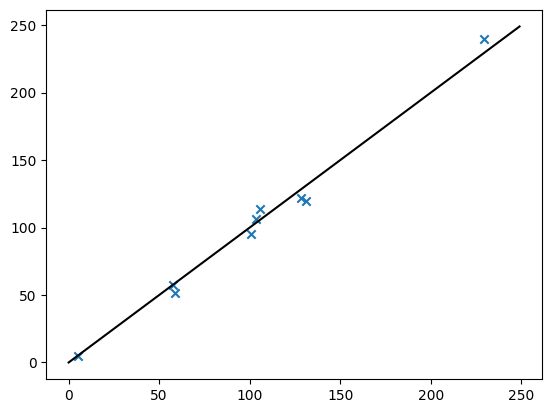

In [95]:
trainer.test(model, ckpt_path='best', datamodule=data_module)

# Tensorboard

In [96]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 98100), started 0:01:07 ago. (Use '!kill 98100' to kill it.)